In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import threading
import time
%matplotlib inline

# Nacteni dat

In [2]:
with open("/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/movielens_1m/items.json",'r') as f:
    items = json.loads(f.read())

with open("/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/movielens_1m/properties.json",'r') as f:
    properties = json.loads(f.read())
    
with open("/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/movielens_1m/user.folds.json",'r') as f:
    user_folds = json.loads(f.read())
    
with open("/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/movielens_1m/users.int2str.json",'r') as f:
    users_int2str = json.loads(f.read())
    
with open("/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/movielens_1m/users.str2int.json",'r') as f:
    users_str2int = json.loads(f.read())
      
ratings = pd.read_csv('/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/movielens_1m/ratings.csv')

with open("/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/movielens_1m/items.int2str.json",'r') as f:
    items_int2str = json.loads(f.read())
    
with open("/home/kuba/ownCloud/ModGen-fac-mat/sample-data-v2/movielens_1m/items.str2int.json",'r') as f:
    items_str2int = json.loads(f.read())

# Faktorizace

In [3]:
import numpy as np
%load_ext line_profiler

In [7]:
class MatrixFactorization:
    def __init__(self, ratings, no_factors):
        self.Ratings = ratings.pivot_table(columns=['itemId'],index=['userId'],values='rating')
        self.Ratings_matrix = self.Ratings.values
        self.Weights = np.isfinite(self.Ratings_matrix).astype(np.float64, copy=False)
        self.Idx = np.isfinite(self.Ratings_matrix)
        self.ratings_dict = dict(ratings.apply(lambda r:( (str(int(r.userId)),str(int(r.itemId))),{
                                                                    'rating':r.rating,
                                                                     }), axis=1).values)
        self.no_factors = no_factors
        self.Users = np.random.rand(self.Ratings.shape[0], no_factors) 
        self.Items = np.random.rand(no_factors, self.Ratings.shape[1])
    '''
    RMSE
    '''  
    def get_error(self, R, U, V, W):
        return np.sum(np.nan_to_num((W * (R - np.dot(U, V))))**2)
    
    '''
    OPTIMAZE
    '''
     
    def optimize_rmse_solver(self, lambda_, no_iterations):
        weighted_errors = []
        R = np.nan_to_num(self.Ratings_matrix)
        V = self.Items
        U = self.Users
        W = self.Idx.astype(np.float64, copy=False)
        
        for ii in range(no_iterations):
            for u, Wu in enumerate(W):
                U[u] = np.linalg.solve(np.dot(V, np.dot(np.diag(Wu), V.T)) + lambda_ * np.eye(self.no_factors),
                                           np.dot(V, np.dot(np.diag(Wu), R[u].T))).T
            for i, Wi in enumerate(W.T):
                V[:,i] = np.linalg.solve(np.dot(U.T, np.dot(np.diag(Wi), U)) + lambda_ * np.eye(self.no_factors),
                                             np.dot(U.T, np.dot(np.diag(Wi), R[:, i])))
            
            if(not ii % 2):
                weighted_errors.append(self.get_error(self.Ratings_matrix, self.Users, self.Items, self.Idx))
                print('{}th iteration is completed'.format(ii))
                print(weighted_errors[-1])

            self.R_hat = np.dot(U,V)
                
        return weighted_errors
    
 
    def optimize_rmse_gradient_descent(self, lambda_, no_iterations, alfa = 0.01):
        weighted_errors = []
        R = np.nan_to_num(self.Ratings_matrix)
        V = self.Items
        U = self.Users
        Idx = self.Idx
        
        for ii in range(no_iterations):
            for i in range(0, len(V.T)):
                for c in range(50):
                    V[:,i] += -alfa * (np.dot((np.dot(V[:,i],U[Idx[:,i],:].T) - R[Idx[:,i],i]), U[Idx[:,i],:]) + lambda_ * V[:,i])
                
            for u in range(0, len(U)):
                for c in range(50):
                    U[u] += -alfa * (np.dot((np.dot(U[u], V[:,Idx[u,:]]) - R[u, Idx[u,:]]), V[:,Idx[u,:]].T) + lambda_* U[u] )
            
            
            if(not ii % 2):
                weighted_errors.append(self.get_error(self.Ratings_matrix, self.Users, self.Items, self.Idx))
                print('{}th iteration is completed'.format(ii))
                print(weighted_errors[-1])
                if(weighted_errors[-1] < 241530):
                    return weighted_errors
            self.R_hat = np.dot(U,V)
                
        return weighted_errors
    
    def plot_rmse(self, weighted_errors):
        plt.plot(np.log(weighted_errors), label="weighted error: "+str(weighted_errors[-1]))
        plt.ylabel("RMSE log scale")
        plt.xlabel("no iterations")

        plt.legend()
        plt.show()
        
    def optimaze(self, lambda_, no_iterations, loss_function="RMSE", method="solver", alfa=0.001):
        if(loss_function == "RMSE" and method == "solver"):
            weighted_errors = self.optimize_rmse_solver(lambda_, no_iterations)
            
        if(loss_function == "RMSE" and method == "gradient-descent"):
            weighted_errors = self.optimize_rmse_gradient_descent(lambda_, no_iterations, alfa)

        self.plot_rmse(weighted_errors)
       

In [8]:
import datetime
MFact = MatrixFactorization(ratings.copy(), 10)

0th iteration is completed
344596.141689
2th iteration is completed
260346.943608
4th iteration is completed
241076.684296


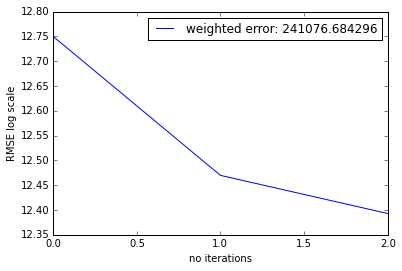

datetime.timedelta(0, 182, 62587)

In [9]:
start_time = datetime.datetime.now()
MFact.optimaze( 0.0001, 400, method="gradient-descent",  alfa = 0.0001)
datetime.datetime.now() - start_time

In [9]:
MFact.Ratings

itemId,1,2,3,5,6,7,9,10,11,12,...,3929,3930,3935,3936,3946,3948,3949,3950,3951,3952
userId,,,,,,,,,,,,,,,,,,,,,
1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,1.0,1.0,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN
100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.0,0.5,1.0,NaN,NaN,NaN,NaN
1000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.5,1.0,0.5
1002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1004,1.0,0.5,-0.5,-1.0,NaN,-0.5,NaN,-0.5,0.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
pd.DataFrame(MFact.R_hat)

,0,1,2,3,4,5,6,7,8,9,...,2596,2597,2598,2599,2600,2601,2602,2603,2604,2605
0,0.953284,0.621520,0.663398,1.022338,0.495027,-0.041229,0.507400,0.570187,0.506290,0.728655,...,0.445392,0.216389,0.269183,0.844067,-0.174674,0.187012,0.773948,1.276962,1.568516,0.509984
1,0.692817,0.692684,0.352735,0.578697,0.122507,0.429022,0.649200,0.600871,0.531353,0.478325,...,0.737237,0.547235,0.623259,0.762311,0.741536,0.739014,0.557779,0.686224,0.690969,0.519559
2,-0.214384,0.575380,0.183705,-0.149497,-0.791797,0.449126,0.118076,-0.766706,-0.716954,-0.001578,...,-0.511449,0.854278,0.078909,-0.062628,0.060264,0.163771,0.298074,0.289498,0.514353,-0.618357
3,1.354482,0.684738,1.014400,1.061513,0.909629,0.560367,0.815324,0.508796,0.358242,0.598787,...,0.635390,0.528613,1.071877,1.056203,0.618705,0.718813,0.788681,0.938402,0.825970,0.863219
4,-0.175071,0.414438,-0.013272,0.246688,-0.037740,0.454720,-0.293503,0.273596,0.415125,-0.171068,...,0.576164,-0.281723,-0.285819,-0.065979,0.374331,0.286432,0.211437,0.147888,0.145928,0.413627
5,0.703753,-0.255891,0.041993,0.603397,0.721815,0.588929,0.078136,0.456020,0.129983,0.786289,...,0.424379,0.088089,0.102438,0.677565,0.099109,0.813642,-0.133571,0.647499,0.339608,0.507083
6,1.223687,0.080849,0.142437,0.571913,0.076413,0.101293,0.703167,0.849216,0.529323,1.118281,...,0.914372,-0.718901,0.073675,0.835350,0.210880,0.987669,-0.403224,-0.435505,0.485628,0.810544
7,0.582852,0.964401,-0.560099,0.216206,0.298100,0.923030,1.491530,0.175431,0.808233,1.042780,...,1.088958,0.085177,0.997634,1.928112,0.029192,1.282443,0.107549,1.369167,0.939945,0.739675
8,0.768521,0.869104,0.389699,0.044996,0.417026,0.380442,0.225656,0.316567,0.156543,0.327527,...,0.091269,0.470833,1.419185,0.856142,0.159617,0.452813,0.209099,0.126081,0.826349,0.828740
9,0.028582,0.177307,0.401374,-0.055239,0.517254,0.045648,0.270915,0.243316,0.265986,0.409383,...,0.169002,0.327146,0.199104,0.361818,0.196477,0.182683,0.385486,0.141552,0.268863,-0.076411


In [148]:
%lprun -f MFact.rmse_optimalization MFact.rmse_optimalization(0.001, 0.0001, 5)

35398.6548163
56954.9876371
78854.8009604
82214.7944852
61871.7728815
